In [1]:
# https://canvas.vu.nl/courses/72644/files/folder/Assignments
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from scipy.interpolate import interp1d

from sources.API import API_call as api
from sources.Cashflows import Cashflows
from sources.datesandrates import DatesAndRates
from sources.plotter import Plotter
from scipy.optimize import fsolve
import numpy_financial as npf

cf = Cashflows()
dt = DatesAndRates()
plot = Plotter()

pd.options.display.float_format = '{:.4f}'.format


## Part 1: IRS

In [2]:
def standardized_maturities(zero_rates):
    """
    Standardize maturity indices for ECB data to yearly scaled indices.

    Parameters:
        zero_rates (pd.Series): Pandas Series containing zero rates with maturity indices.

    Returns:
        list: A list of standardized maturity values in years.

    This function standardizes the maturity indices provided in the ECB data to yearly scaled indices. It processes each
    maturity index, which can be in the format "X months" or "X years," and converts them into a yearly scale for
    consistent handling.
    """
    standardized_maturities = []
    for maturity in zero_rates.index:
        if 'month' in maturity:
            num_months = int(maturity.split()[0])
            standardized_maturities.append(num_months / 12.0)
        elif 'year' in maturity:
            num_years = int(maturity.split()[0])
            standardized_maturities.append(num_years)
        else:
            raise ValueError(f"Unrecognized maturity format: {maturity}")
    return standardized_maturities

# Importing Data: 
usbond_df = pd.read_excel('data/usbond_data.xlsx')
bondtest_data = pd.read_excel('data/bondtest_data.xlsx')
european_zerorates = pd.read_excel('data/european_zerorates.xlsx')
european_zerorates = european_zerorates.set_index('Maturity')
european_zerorates =  european_zerorates['AAA rated']/100 #make percentages
european_zerorates.index = standardized_maturities(european_zerorates)

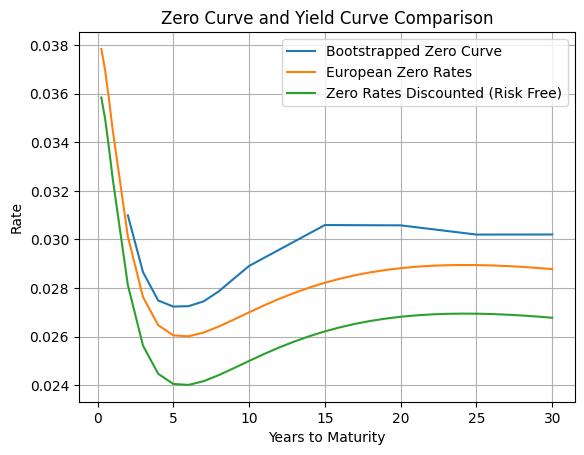

In [3]:
bond_price_1procent_coupon = {
    '2 years': 95.96,
    '3 years': 94.68,
    '4 years': 93.43,
    '5 years': 92.01,
    '6 years': 90.53,
    '7 years': 88.98,
    '8 years': 87.30,
    '9 years': 85.52,
    '10 years': 83.72,
    '15 years': 75.45,
    '20 years': 69.50,
    '25 years': 64.90,
    '30 years': 60.55,
}
euribor_rates = api.get_euribordata()
euribor_rates_list = [0.03896, 0.03834, euribor_rates[0.25], euribor_rates[0.5], euribor_rates[1]]

euribor_rates = {
    '1 week': euribor_rates_list[0],
    '1 month': euribor_rates_list[1],
    '3 month': euribor_rates_list[2],
    '6 months': euribor_rates_list[3],
    '12 months': euribor_rates_list[4]
}


bond_maturities = [
    2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30
]

yields = [
    3.114, 2.878, 2.757, 2.731, 2.732, 2.753, 2.793, 2.846, 2.899, 3.066, 3.062, 3.020, 3.017
]

def bond_price_from_yields(yield_rate, bond_maturities, face_value, coupon_rate, payments_per_year):
    periods = bond_maturities * payments_per_year
    discount_factor = np.exp(-yield_rate/100/payments_per_year)#1/(1+yield_rate/100/payments_per_year)
    pv_coupons = npf.pv(rate= yield_rate/100/payments_per_year, nper=periods, pmt=coupon_rate/payments_per_year, when=1)
    pv_face_value = face_value * discount_factor ** periods
    return pv_coupons + pv_face_value
    
    
def bootstrap_zero_curve(bond_price_1procent_coupon, euribor_rates, bond_maturities, face_value, payments_per_year, coupon_rate):
    zero_curve = pd.DataFrame(index=bond_maturities, columns=['Zero Rates'])
    #first_rate = pd.DataFrame(euribor_rates.iloc[:], index=1)
    #print(first_rate)
    
    for i, maturity in enumerate(bond_maturities):
        initial_gues= 0.02
        zero_rate = fsolve(lambda x: bond_price_from_yields(x, maturity, face_value, coupon_rate, payments_per_year)-bond_price_1procent_coupon[f'{maturity} years'], x0=initial_gues)[0]
        zero_curve.at[maturity] = zero_rate#+0.04
        
        #print(f'Maturity: {maturity} years, Zero Rate: {zero_rate}, Bond Price: {bond_price_from_yields(zero_rate, maturity,face_value, coupon_rate, payments_per_year)}')
    
    #print(zero_curve)
    return(zero_curve)

face_value = 100
payments_per_year = 1
coupon_rate = -1

zero_curve = bootstrap_zero_curve(bond_price_1procent_coupon, euribor_rates, bond_maturities, face_value, payments_per_year, coupon_rate) 
zero_curve = zero_curve/100
zero_curve_rf = european_zerorates - 0.002
plot.plot_zerorates(zero_curve, european_zerorates, zero_curve_rf)


In [4]:
european_zerorates

0.2500    0.0378
0.5000    0.0370
0.7500    0.0358
1.0000    0.0345
2.0000    0.0301
3.0000    0.0276
4.0000    0.0265
5.0000    0.0261
6.0000    0.0260
7.0000    0.0262
8.0000    0.0264
9.0000    0.0267
10.0000   0.0270
11.0000   0.0273
12.0000   0.0276
13.0000   0.0278
14.0000   0.0280
15.0000   0.0282
16.0000   0.0284
17.0000   0.0285
18.0000   0.0286
19.0000   0.0287
20.0000   0.0288
21.0000   0.0289
22.0000   0.0289
23.0000   0.0289
24.0000   0.0289
25.0000   0.0289
26.0000   0.0289
27.0000   0.0289
28.0000   0.0289
29.0000   0.0288
30.0000   0.0288
Name: AAA rated, dtype: float64

Overview code: 

In [5]:
def calc_swaprate(notional_amount, payment_dates, payment_frequency, amortization_schedule, floating_rate_curve, euribor_data, discount_rate_cash_flow):
    guess_rate = 0.01 #adjusting rate (precision)
    tolerance = 0.001 #difference pv between floating and fixed rate
    max_iterations = 10000000 
    delta_rate = 0.0001

    for i in range(max_iterations):
        # Calc NPV for guess:
        floating_cash_flows = cf.calculate_floating_cashflow(notional_amount, payment_dates, payment_frequency, floating_rate_curve, amortization_schedule, euribor_data)
        fixed_cash_flows = cf.calculate_fixed_cashflow(notional_amount, payment_dates, payment_frequency, guess_rate, amortization_schedule)
        net_cash_flow = fixed_cash_flows - floating_cash_flows
        npv_value = cf.discount_cash_flows(net_cash_flow, payment_dates, discount_rate_cash_flow)[0]
        fixed_cash_flows_delta = cf.calculate_fixed_cashflow(notional_amount, payment_dates, payment_frequency, guess_rate + delta_rate, amortization_schedule)
        net_cash_flow_delta = fixed_cash_flows_delta- floating_cash_flows
        npv_value_delta = cf.discount_cash_flows(net_cash_flow_delta, payment_dates, discount_rate_cash_flow)[0]

        derivative = (npv_value_delta - npv_value) / delta_rate
        
        # Update guess_rate using Newton-Raphson formula
        if abs(derivative) > 1e-10:  # Avoid division by zero
            guess_rate -= npv_value / derivative
        else:
            break
        
        if abs(npv_value) < tolerance: 
            return guess_rate

        guess_rate += npv_value * 0.001  # Simplified adjustment, use a proper numerical method

    raise ValueError("Swap rate not found within maximum iterations")

In [6]:
def IRS_enginge(notional_amount, zero_rates, maturity, payment_frequency, fixed_rate, first_receiving_date,amortization_schedule=None, one_curve=True, already_issued = True, fix_to_floating= True, print_output = True, give_results = False):
    """
    Calculate the net present value (NPV) of an interest rate swap.

    Parameters:
        zero_rate (pd.Series or float): Zero rates for discounting or a single zero rate if 'one_curve' is True.
        notional (float): The initial notional amount.
        start_date (pd.Timestamp): The start date of the interest rate swap.
        end_date (pd.Timestamp): The end date of the interest rate swap.
        payment_frequency (float): Payment frequency (e.g., 0.25 for quarterly, 0.5 for semi-annual, 1 for annual).
        fixed_rate (float): The fixed interest rate for the swap.
        swap_type (str, optional): Type of interest rate swap (default is 'fixed_vs_floating').
        amortization_schedule (list, optional): Amortization schedule if applicable (default is None).
        one_curve (bool, optional): Boolean flag to indicate whether to use a single curve or two curves (default is True).

    Returns:
        float: The net present value (NPV) of the interest rate swap.

    This function calculates the NPV of an interest rate swap based on the provided parameters. It takes into account the
    type of swap, payment frequency, and whether to use a single curve or two curves for discounting.
    """

    euribor = api.get_euribordata()
    payment_dates, zero_rates_aligned, euribor_data = dt.run(maturity, first_receiving_date, payment_frequency, zero_rates, euribor)

    if one_curve == True:
        floating_rate_curve = zero_rates_aligned
        discount_rate_cash_flow = zero_rates_aligned
    else: 
        floating_rate_curve = zero_rates_aligned
        discount_rate_cash_flow = {key: value - 0.002 for key, value in zero_rates_aligned.items()}

    if already_issued == True: 
        floating_cash_flows = cf.calculate_floating_cashflow(notional_amount, payment_dates, payment_frequency, floating_rate_curve, amortization_schedule, euribor_data)
        fixed_cash_flows = cf.calculate_fixed_cashflow(notional_amount, payment_dates, payment_frequency, fixed_rate, amortization_schedule)

        if fix_to_floating == True: #(book example)
            net_cash_flow = floating_cash_flows - fixed_cash_flows
            npv, discount_factor_list, npv_list = cf.discount_cash_flows(net_cash_flow, payment_dates, discount_rate_cash_flow)
        else: 
            net_cash_flow =  fixed_cash_flows - floating_cash_flows
            npv, discount_factor_list, npv_list = cf.discount_cash_flows(net_cash_flow, payment_dates, discount_rate_cash_flow)

        if print_output == True:
            print(f'NPV using the fixed rate ({fixed_rate}): {npv}')

        if give_results ==True: 
            table_output = {
            'Time': payment_dates,
            'Fixed cash flow': fixed_cash_flows,
            'Floating cash flow': floating_cash_flows,
            'Net cash flow': net_cash_flow,
            'Discount factor': discount_factor_list,
            'Present value of net cash flow': npv_list,
            }
            return npv,table_output
        else: 
            return npv
    
    else:
        swap_rate = calc_swaprate(notional_amount, payment_dates, payment_frequency, amortization_schedule, floating_rate_curve, euribor_data, discount_rate_cash_flow)
        if print_output == True:
            print(f'Swap rate equals: {np.round(swap_rate,10)}')

        return swap_rate

In [7]:
Scenarios = {}

# Book example:
data = {
    'libor_rates': [0.028, 0.032, 0.034],
    'maturities': [3/12, 9/12, 15/12]
}
df = pd.DataFrame(data)
df.set_index('maturities', inplace=True)
df.index.name = None
df.columns = ['Libor Rate']
libor_rates_series = df.squeeze()

maturity = 1.25
first_receiving_date = 0.25
payment_frequency = 0.5
fixed_rate = 0.03
notional_amount = 100000000
already_issued = True
one_curve = True
curves = [True, False]

for curve in curves: 
    Scenarios['scenario1'], results  = IRS_enginge(notional_amount, libor_rates_series, maturity, payment_frequency, fixed_rate, first_receiving_date, amortization_schedule=None, one_curve=curve, already_issued = already_issued, give_results=True)


NPV using the fixed rate (0.03): 511732.2561638602
NPV using the fixed rate (0.03): 512902.7747570311


In [10]:
Scenarios = {}

# Book example:
data = {
    'libor_rates': [0.028, 0.032, 0.034],
    'maturities': [3/12, 9/12, 15/12]
}
df = pd.DataFrame(data)
df.set_index('maturities', inplace=True)
df.index.name = None
df.columns = ['Libor Rate']
libor_rates_series = df.squeeze()

maturity = 1.25
first_receiving_date = 0.25
payment_frequency = 0.5
fixed_rate = 0.03
notional_amount = 100000000
already_issued = True
one_curve = True

Scenarios['scenario1'], results  = IRS_enginge(notional_amount, libor_rates_series, maturity, payment_frequency, fixed_rate, first_receiving_date, amortization_schedule=None, one_curve=one_curve, already_issued = already_issued, give_results=True)

scenario_df = pd.DataFrame(results)
scenario_df['Time'] = scenario_df['Time'].map('{:.2f}'.format)  # Format the 'Time' to two decimal places
scenario_df.set_index('Time', inplace=True)
scenario_df.index.name = None
scenario_df.to_csv(r'D:\studie\main_studie\files\stochastics_finance\E_FIN_SPFDM-1\assignment 1\outputs\scenario1.csv')

NPV using the fixed rate (0.03): 511732.2561638602


In [ ]:
Scenarios['scenario2'] = {}

maturities = np.arange(1,10+1, 1)
first_receiving_date = 0
fixed_rate = 0.045
notional_amount = 100

already_issued = False
one_curve = True
fix_to_floating = True

payment_frequencies = [0.25, 0.5, 1]
bumps = np.array([-150, -100, -50, -25, 0, 25, 50, 100, 150]) / 100000


In [9]:
Scenarios['scenario2'] = {}

# Cases:
# 1. swap rate impact on payment frequency
# 2. different levels of current zero curve
# 3. swap rate impact on amortizing

maturities = np.arange(5,7+1, 1)
maturity = maturities[0]
first_receiving_date = 0
fixed_rate = 0.045
notional_amount = 100

already_issued = False
one_curve = True
fix_to_floating = True

payment_frequencies = [0.25, 0.5, 1]
for curve in curves: 
    print(f'One Curve: {curve}')
    for payment_frequency in payment_frequencies:
        print(f'\nPayment frequency: {payment_frequency}')
        Scenarios['scenario2'][f'{payment_frequency} pay/freq']  = IRS_enginge(notional_amount, european_zerorates, maturity, payment_frequency, fixed_rate, first_receiving_date, amortization_schedule=None, one_curve=curve, already_issued = already_issued)

One Curve: True

Payment frequency: 0.25
Swap rate equals: 0.0264108327

Payment frequency: 0.5
Swap rate equals: 0.0266133176

Payment frequency: 1
Swap rate equals: 0.0269630878
One Curve: False

Payment frequency: 0.25
Swap rate equals: 0.0264003428

Payment frequency: 0.5
Swap rate equals: 0.0266028152

Payment frequency: 1
Swap rate equals: 0.0269529699


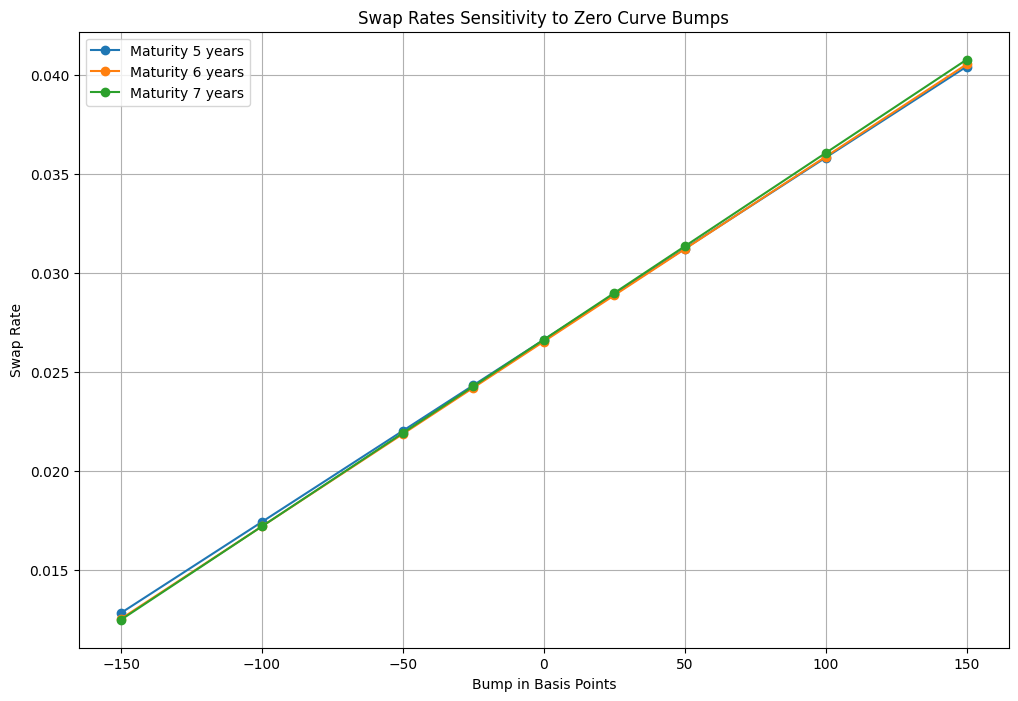

In [364]:
payment_frequency = 0.5
bumps = np.array([-150, -100, -50, -25, 0, 25, 50, 100, 150]) / 10000
Scenarios['scenario2']['bumps'] = []
already_issued = False
payment_frequency = 0.5
maturities = np.arange(5,7+1, 1)
first_receiving_date = 0
notional_amount = 100

for maturity in maturities:
    Scenarios['scenario2'][maturity] = {f'{bump*10000}bp': [] for bump in bumps}

# Calculate swap rates for different bumps and maturities
for bump in bumps:
    for maturity in maturities:
        bumped_curve = european_zerorates + bump
        swap_rate = IRS_enginge(notional_amount, bumped_curve, maturity, payment_frequency, fixed_rate, first_receiving_date, None, one_curve, already_issued, print_output=False)
        Scenarios['scenario2'][maturity][f'{bump*10000}bp'].append(swap_rate)

plot.plot_bumps(Scenarios, bumps, maturities)

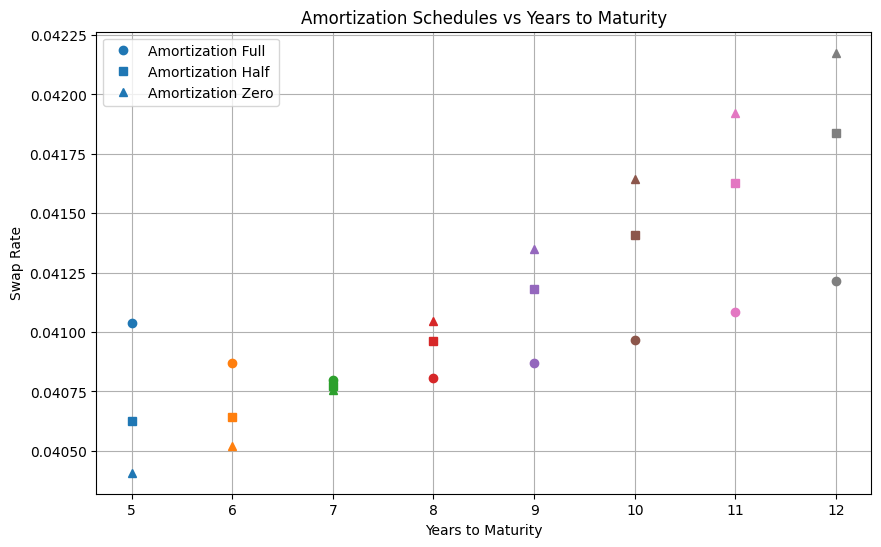

In [332]:
payment_frequency = 0.5
maturities = np.arange(5,12+1, 1)
first_receiving_date = 0
notional_amount = 100

already_issued = False
one_curve = True
fix_to_floating = True

amortization_schedules = np.array([0,notional_amount/2,notional_amount])

Scenarios['scenario2']['part2'] = {}

for maturity in maturities:
    Scenarios['scenario2']['part2'][maturity] = {}
    Scenarios['scenario2']['part2'][maturity]['amortization'] = []
    Scenarios['scenario2']['part2'][maturity]['amortization_schedule'] = amortization_schedules

    for amortization in amortization_schedules:
        amortization_schedule= dt.create_amortization_schedule(notional_amount=notional_amount, final_notional=amortization, payment_frequency=payment_frequency, maturity=maturity, first_receiving_date=0)
        swap_rates = IRS_enginge(notional_amount, bumped_curve, maturity, payment_frequency, fixed_rate, first_receiving_date, amortization_schedule=amortization_schedule, one_curve=one_curve, already_issued = already_issued, print_output=False)
        Scenarios['scenario2']['part2'][maturity]['amortization'].append(swap_rates)

# plot.plot_swap_rates(Scenarios)
plot.plot_amortization_schedules(Scenarios)

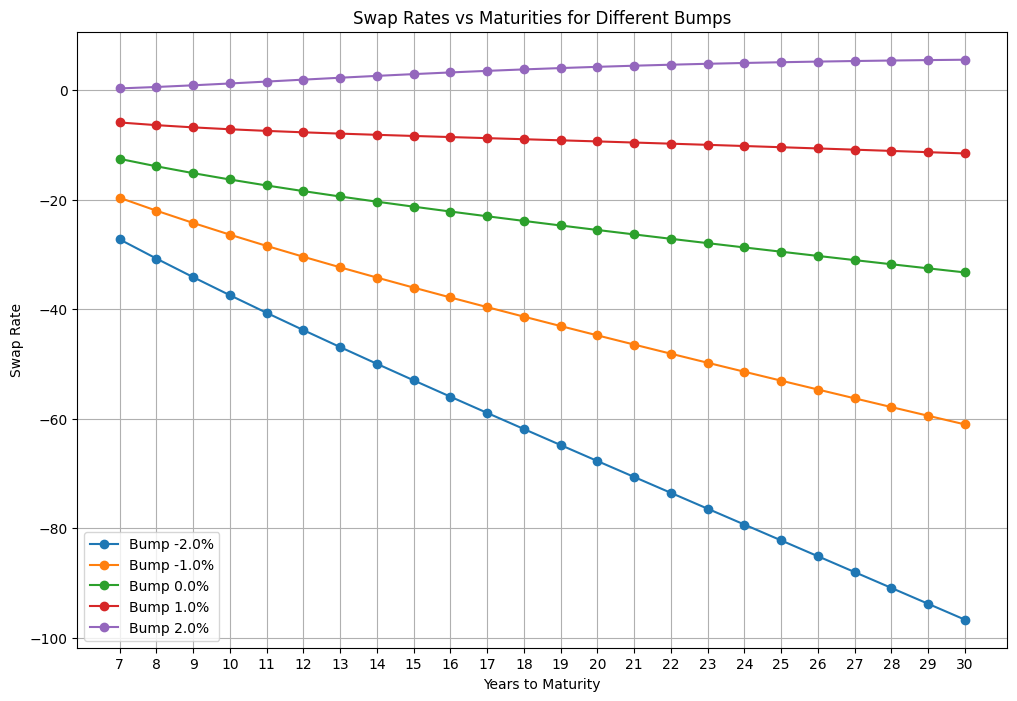

In [333]:
payment_frequency = 0.5
maturities = np.arange(7, 30+1, 1)
first_receiving_date = 0
notional_amount = 100
fixed_rate = 0.045
already_issued = True
one_curve = True
fix_to_floating = True
bumps = np.array([-200, -100, 0, 100, 200]) / 10000

Scenarios['scenario3'] = {}

for bump in bumps: 
    Scenarios['scenario3'][f'{bump*100}%'] = []
    for maturity in maturities: 
        bumped_curve = european_zerorates + bump
        swap_value = IRS_enginge(notional_amount, bumped_curve, maturity, payment_frequency, fixed_rate, first_receiving_date, amortization_schedule=None, one_curve=one_curve, already_issued = already_issued, print_output = False)
        
        Scenarios['scenario3'][f'{bump*100}%'].append(swap_value)

plot.plot_bumped_swap_rates(Scenarios, maturities)